# Comparing different structures

Sometimes you want to compare the contact map of two things that have different topologies. This example notebook will run through a couple of common occurences and the options for those. 



## Looking at a truncated protein

One option is to look at the difference between a truncated protein and the full protein. Here we will fake truncating the protein at residue `150`. This works with just subtracting, as that will only care about possible contacts that can be present in both maps.


In [1]:
import mdtraj as md
from contact_map import ContactFrequency 

In [2]:
full = md.load("data/gsk3b_example.h5") # Start with the full trajectory from another example

# Slice another trajectory down to 150 residues
truncated = full.atom_slice(full.topology.select("resid 0 to 150")) 

map_full = ContactFrequency(full)

# Here we just use 1 frame so there is a difference to show
map_truncated = ContactFrequency(truncated[0])


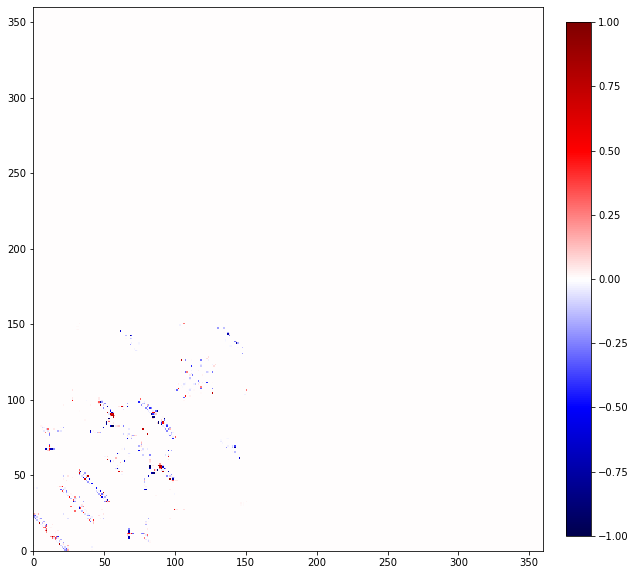

In [3]:
diff = map_full - map_truncated 

# This will only show data for up to residue 150, as differences don't make sense outside of that region
diff.residue_contacts.plot(figsize=(10,10));

## Comparing mutated proteins.

In order to look at the contact map difference between for example a WT and a mutated protein there are a couple options. We will use the KRAS pdb's [4OBE](https://www.rcsb.org/structure/4obe) (WT) and [5V9O](https://www.rcsb.org/structure/5V9O) (G12C).

In [4]:
WT_full = md.load("data/4obe.pdb") # Load the wildtype structure
# This pdb contains 2 protein chains and we only want one
WT_chain1 = WT_full.atom_slice([i.index for i in WT_full.topology.chain(0).atoms])


G12C_full = md.load("data/5v9o.pdb") # Load the mutated structure
# Cut this one down to just the protein
G12C_protein = G12C_full.atom_slice(G12C_full.topology.select("protein"))

wt_map = ContactFrequency(WT_chain1)
g12c_map = ContactFrequency(G12C_protein)

print(wt_map.topology.residue(11)) 
print(g12c_map.topology.residue(11))

GLY12
CYS12


 If we now try to subtract the two, this will fail because we can't overlap the atom contact maps

In [5]:
#diff = wt_map - g12c_map # This will fail, because the atom indices don't make sense

But, we can still look at the residues by using `AtomMismatchedContactDifference`. All the `ContactDifference` objects will only show differences between contacts that can be present in the map. So in this case it will not show any differences for residue `168` (GDP) which is only present for the wildtype. 

[([GLY/CYS12, LYS16], 0.0)]


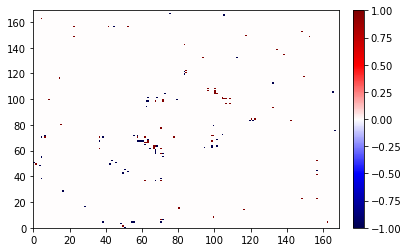

In [6]:
from contact_map import AtomMismatchedContactDifference

diff = AtomMismatchedContactDifference(wt_map, g12c_map)

# Grab residue 12
res = diff.topology.residue(11)

# Print the contact differences between WT and G12C (this will print GLY/CYS12 as residue name)
print(diff.residue_contacts.most_common(res))
diff.residue_contacts.plot();

## Looking at difference when the residue information is missing

Sometimes it can happen that the residue information is missing or does not make sense. This is more common for DFT-md simulations than protein simulations, but we will break one of the topologies here to illustrate this behavior and how to handle it

In [7]:
full = full
# Make a copy by slicing it to the same number of atoms
broken = full.atom_slice(range(full.topology.n_atoms))
# Here we break the residues, making all resSeqs equal
for i in range(broken.topology.n_residues):
    broken.topology.residue(i).resSeq = "broken"
    
# We also have to break a name, as otherwise mdtraj thinks the topologies are equal
broken.topology.residue(0).name = "test"
    
map_full = ContactFrequency(full)
map_broken = ContactFrequency(broken[0])

Here the atoms are correct, but we don't know if the residues would make sense so we can use `ResidueMismatchedContactDifference` if we only care about the atom-contacts.

/home/sander/github_files/contact_map/contact_map/contact_count.py:176: RuntimeWarning: The number of pixels in the figure is insufficient to show all the contacts.
 Please save this as a vector image (such as a PDF) to view the correct result.
 Another option is to increase the 'dpi' (currently: 72.0), or the 'figsize' (currently: (6.0, 4.0)).
 Recommended minimum amount of pixels = (5704, 5704) (width, height).
  warnings.warn(msg, RuntimeWarning)


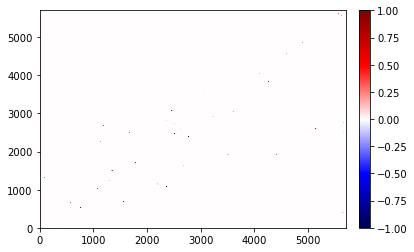

In [8]:
from contact_map import ResidueMismatchedContactDifference
# diff = map_full - map_broken
diff = ResidueMismatchedContactDifference(map_full, map_broken)
diff.atom_contacts.plot();

The other option is to override the topology if we have a correct one (in this case `full.topology`), then we can use `OverrideTopologyContactDifference`

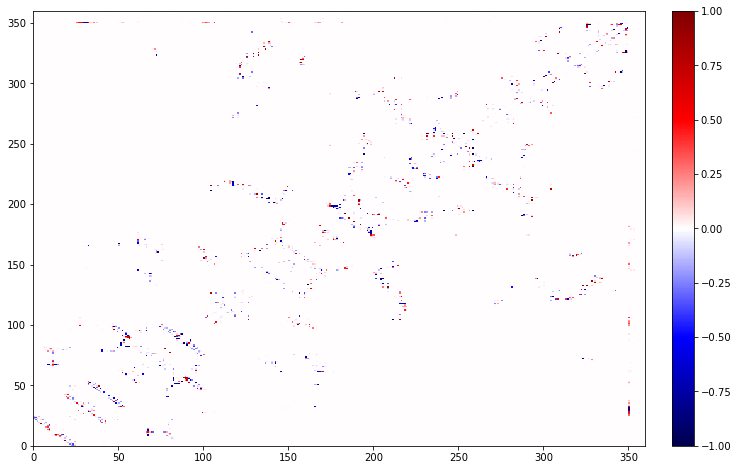

In [9]:
from contact_map import OverrideTopologyContactDifference
diff = OverrideTopologyContactDifference(map_full, map_broken, topology=full.topology)
diff.residue_contacts.plot(figsize=(12,8));